In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class CNN(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 filter_sizes=[64, 64, 64, 64, 64], 
                 kernel_sizes=[3, 3, 3, 3, 3],
                 activation_fn=nn.ReLU(),
                 dense_neurons=256,
                 input_size=(224, 224),
                 use_batchnorm=False,
                 dropout_rate=0.0):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.use_batchnorm = use_batchnorm
        self.activation_fn = activation_fn
        
        # First layer takes the input channels
        channels = [in_channels] + filter_sizes
        
        # Create the convolutional blocks
        for i in range(len(filter_sizes)):
            self.conv_layers.append(
                nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel_sizes[i], padding=kernel_sizes[i]//2)
            )
            if self.use_batchnorm:
                self.batch_norms.append(nn.BatchNorm2d(channels[i+1]))
        
        # Calculate the output dimensions after convolutions and pooling
        # Start with the input dimensions
        height, width = input_size
        
        # After each conv layer, we have a max pooling with kernel size 2 and stride 2
        for _ in range(len(filter_sizes)):
            # Max pooling reduces dimensions by half
            height //= 2
            width //= 2
        
        # Calculate flattened feature size
        flattened_size = filter_sizes[-1] * height * width
        
        # Define fully connected layers
        self.fc1 = nn.Linear(flattened_size, dense_neurons)
        self.fc2 = nn.Linear(dense_neurons, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        # Apply convolution blocks
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            if self.use_batchnorm:
                x = self.batch_norms[i](x)
            x = self.activation_fn(x)
            x = F.max_pool2d(x, 2, 2)  # Max pooling with 2x2 kernel and stride 2
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [3]:
import os
from PIL import Image

In [4]:
# Dataset class for the iNaturalist dataset
class iNaturalistDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(self.class_dirs))}
        
        self.samples = []
        for class_dir in self.class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            class_idx = self.class_to_idx[class_dir]
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_path, img_name), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
# Function to create stratified train-validation split
def create_stratified_splits(dataset, val_ratio=0.2, random_state=42):
    # Get all labels
    labels = [sample[1] for sample in dataset.samples]
    
    # Get indices for train and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(dataset)),
        test_size=val_ratio,
        random_state=random_state,
        stratify=labels
    )
    
    # Create subset datasets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    return train_dataset, val_dataset

In [7]:
# Function to train the model for one epoch
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(X)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

In [8]:
# Function to validate the model
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            val_loss += criterion(output, y).item()
            _, predicted = output.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

In [9]:
# Function to test the model
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    images = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            _, predicted = output.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            
            # Store some examples for visualization
            if len(images) < 30:  # Store up to 30 images
                batch_images = X.cpu().numpy().transpose(0, 2, 3, 1)
                batch_preds = predicted.cpu().numpy()
                batch_targets = y.cpu().numpy()
                
                for i in range(min(len(batch_images), 3)):  # Store 3 images per batch
                    images.append(batch_images[i])
                    predictions.append(batch_preds[i])
                    true_labels.append(batch_targets[i])
    
    test_acc = 100. * correct / total
    
    return test_acc, images, predictions, true_labels

In [20]:
def train_model(config=None):
    """
    Train the CNN model without wandb integration for testing.
    
    Args:
        config: Dictionary containing hyperparameters.
    """
    # Default config if none is provided
    if config is None:
        config = {
            'learning_rate': 0.0013739826631674829,
            'batch_size': 128,
            'epochs': 10,
            'first_layer_filters': 64,
            'kernel_size': 3,
            'dense_neurons': 256,
            'activation': 'mish',
            'filter_organization': 'same',
            'use_augmentation': True,
            'use_batchnorm': True,
            'dropout_rate': 0.5,
            'weight_decay': 0.001
        }
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set up data augmentation based on config
    if config['use_augmentation']:
        train_transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    val_transform = transforms.Compose([
        transforms.Resize((124, 124)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    print("Loading datasets...")
    # Update this path to your actual dataset path
    data_path = 'nature_12K/inaturalist_12K/train'
    
    full_train_dataset = iNaturalistDataset(root_dir=data_path, transform=train_transform)
    train_dataset, val_dataset = create_stratified_splits(full_train_dataset)
    
    # Reset transforms for validation set
    val_dataset.dataset.transform = val_transform
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
    
    print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")
    
    # Get activation function based on config
    activation_map = {
        'relu': nn.ReLU(),
        'gelu': nn.GELU(),
        'silu': nn.SiLU(),
        'mish': nn.Mish()
    }
    activation_fn = activation_map[config['activation']]
    
    # Define filter sizes based on config
    if config['filter_organization'] == 'same':
        filter_sizes = [config['first_layer_filters']] * 5
    elif config['filter_organization'] == 'double':
        filter_sizes = [config['first_layer_filters']]
        for _ in range(4):
            filter_sizes.append(filter_sizes[-1] * 2)
    elif config['filter_organization'] == 'half':
        filter_sizes = [config['first_layer_filters']]
        for _ in range(4):
            filter_sizes.append(max(filter_sizes[-1] // 2, 16))  # Minimum 16 filters
    
    print(f"Filter sizes: {filter_sizes}")
    
    # Create the model
    model = CNN(
        in_channels=3,
        num_classes=10,  # Assuming 10 classes in iNaturalist subset
        filter_sizes=filter_sizes,
        kernel_sizes=[config['kernel_size']] * 5,
        activation_fn=activation_fn,
        dense_neurons=config['dense_neurons'],
        input_size=(124, 124),
        use_batchnorm=config['use_batchnorm'],
        dropout_rate=config['dropout_rate']
    ).to(device)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    # Track best validation accuracy
    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = validate(model, device, val_loader, criterion)
        
        print(f'Epoch: {epoch}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")
    
    print(f"Training complete. Best validation accuracy: {best_val_acc:.2f}%")
    return model, best_val_acc

In [21]:
train_model()

Using device: cuda
Loading datasets...
Train dataset size: 7999, Validation dataset size: 2000
Filter sizes: [64, 64, 64, 64, 64]
Model created with 300426 parameters
Train Epoch: 1 [0/7999 (0%)]	Loss: 2.382533
Train Epoch: 1 [2560/7999 (32%)]	Loss: 2.152888
Train Epoch: 1 [5120/7999 (63%)]	Loss: 2.068313
Train Epoch: 1 [7680/7999 (95%)]	Loss: 1.943245
Epoch: 1
Train Loss: 2.1118, Train Acc: 23.68%
Val Loss: 2.1864, Val Acc: 23.45%
New best model saved with validation accuracy: 23.45%
Train Epoch: 2 [0/7999 (0%)]	Loss: 1.962084
Train Epoch: 2 [2560/7999 (32%)]	Loss: 1.998038
Train Epoch: 2 [5120/7999 (63%)]	Loss: 2.020363
Train Epoch: 2 [7680/7999 (95%)]	Loss: 1.898505
Epoch: 2
Train Loss: 1.9597, Train Acc: 29.87%
Val Loss: 1.9316, Val Acc: 31.25%
New best model saved with validation accuracy: 31.25%
Train Epoch: 3 [0/7999 (0%)]	Loss: 1.860539
Train Epoch: 3 [2560/7999 (32%)]	Loss: 1.937325
Train Epoch: 3 [5120/7999 (63%)]	Loss: 1.859181
Train Epoch: 3 [7680/7999 (95%)]	Loss: 1.847660

(CNN(
   (conv_layers): ModuleList(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1-4): 4 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   )
   (batch_norms): ModuleList(
     (0-4): 5 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (activation_fn): Mish()
   (fc1): Linear(in_features=576, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=10, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 37.35)

In [14]:
import wandb

In [ ]:
# Main training function with wandb integration
def train_with_wandb(config=None):
    # Initialize a new wandb run

    with wandb.init(config=config) as run:
        # If called by wandb.agent, use the config set by sweep controller
        config = wandb.config
        
        # Generate a descriptive name for the run based on key hyperparameters
        run_name = f"f{config.first_layer_filters}-{config.filter_organization[:2]}-k{config.kernel_size}-{config.activation[:2]}-d{int(config.dropout_rate*100)}-bn{int(config.use_batchnorm)}-aug{int(config.use_augmentation)}"
        run.name = run_name
        run.save()
        
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Set up data augmentation based on config
        if config.use_augmentation:
            train_transform = transforms.Compose([
                transforms.Resize((124, 124)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((124, 124)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        val_transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load datasets
        full_train_dataset = iNaturalistDataset(root_dir='nature_12K/inaturalist_12K/train', transform=train_transform)
        train_dataset, val_dataset = create_stratified_splits(full_train_dataset)
        
        # Reset transforms for validation set
        val_dataset.dataset.transform = val_transform
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
        
        # Get activation function based on config
        activation_map = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }
        activation_fn = activation_map[config.activation]
        
        # Define filter sizes based on config
        if config.filter_organization == 'same':
            filter_sizes = [config.first_layer_filters] * 5
        elif config.filter_organization == 'double':
            filter_sizes = [config.first_layer_filters]
            for _ in range(4):
                filter_sizes.append(filter_sizes[-1] * 2)
        elif config.filter_organization == 'half':
            filter_sizes = [config.first_layer_filters]
            for _ in range(4):
                filter_sizes.append(max(filter_sizes[-1] // 2, 16))  # Minimum 16 filters
        
        # Create the model
        model = CNN(
            in_channels=3,
            num_classes=10,  # Assuming 10 classes in iNaturalist subset
            filter_sizes=filter_sizes,
            kernel_sizes=[config.kernel_size] * 5,
            activation_fn=activation_fn,
            dense_neurons=config.dense_neurons,
            input_size=(124, 124),
            use_batchnorm=config.use_batchnorm,
            dropout_rate=config.dropout_rate
        ).to(device)
        
        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        
        # Track best validation accuracy
        best_val_acc = 0.0
        
        # Training loop
        for epoch in range(1, config.epochs + 1):
            train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
            val_loss, val_acc = validate(model, device, val_loader, criterion)
            
            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })
            
            print(f'Epoch: {epoch}')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f'best_model_{run_name}.pth')
        
        # Log best validation accuracy
        wandb.log({"best_val_acc": best_val_acc})

In [13]:
# Define sweep config for hyperparameter search
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'value': 10
        },
        'first_layer_filters': {
            'values': [16, 32, 64]
        },
        'kernel_size': {
            'values': [3, 5]
        },
        'dense_neurons': {
            'values': [128, 256, 512]
        },
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'filter_organization': {
            'values': ['same', 'double', 'half']
        },
        'use_augmentation': {
            'values': [True, False]
        },
        'use_batchnorm': {
            'values': [True, False]
        },
        'dropout_rate': {
            'values': [0.0, 0.2, 0.3, 0.5]
        },
        'weight_decay': {
            'values': [0.0, 0.0001, 0.001]
        }
    }
}

In [17]:
# Initialize wandb and sweep
os.environ["WANDB_NOTEBOOK_NAME"] = "partA.ipynb"

wandb.login()

True

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='DA6401-Assignment-2')

# Run the sweep
wandb.agent(sweep_id, train_with_wandb, count=25)  # Run 25 experiments

In [19]:
import matplotlib.pyplot as plt

In [ ]:
# Load the best model and evaluate on test set
def evaluate_best_model(use_augmentation=True):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Set up data augmentation based on config
    if use_augmentation == True:
        test_transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        test_transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Load test dataset
    test_dataset = iNaturalistDataset(root_dir='nature_12K/inaturalist_12K/val', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    # Create model with best hyperparameters (these should be from your best run)
    best_model = CNN(
        in_channels=3,
        num_classes=10,  
        filter_sizes=[64, 64, 64, 64, 64],
        kernel_sizes=[3, 3, 3, 3, 3],
        activation_fn=nn.Mish(),
        dense_neurons=256,
        input_size=(124, 124),
        use_batchnorm=True,
        dropout_rate=0.5
    ).to(device)
    
    # Load the saved weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    
    # Evaluate on test set
    test_acc, images, predictions, true_labels = test(best_model, device, test_loader)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Get class names
    class_names = list(test_dataset.class_to_idx.keys())
    
    # Visualize predictions
    fig, axes = plt.subplots(10, 3, figsize=(15, 30))
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            if i*3 + j < len(images):
                idx = i*3 + j
                image = images[idx]
                pred = predictions[idx]
                true = true_labels[idx]
                
                # Convert image from normalized tensor to displayable image
                image = np.clip(image, 0, 1)  # Clip to [0, 1] range
                
                ax.imshow(image)
                ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
                ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('test_predictions.png')
    
    # Log to wandb
    wandb.init(project='DA6401-Assignment-2', name='test_evaluation')
    wandb.log({"test_accuracy": test_acc, "prediction_grid": wandb.Image(fig)})

    wandb.finish()

Test Accuracy: 36.77%


d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


test_accuracy,▁
test_accuracy,36.77368


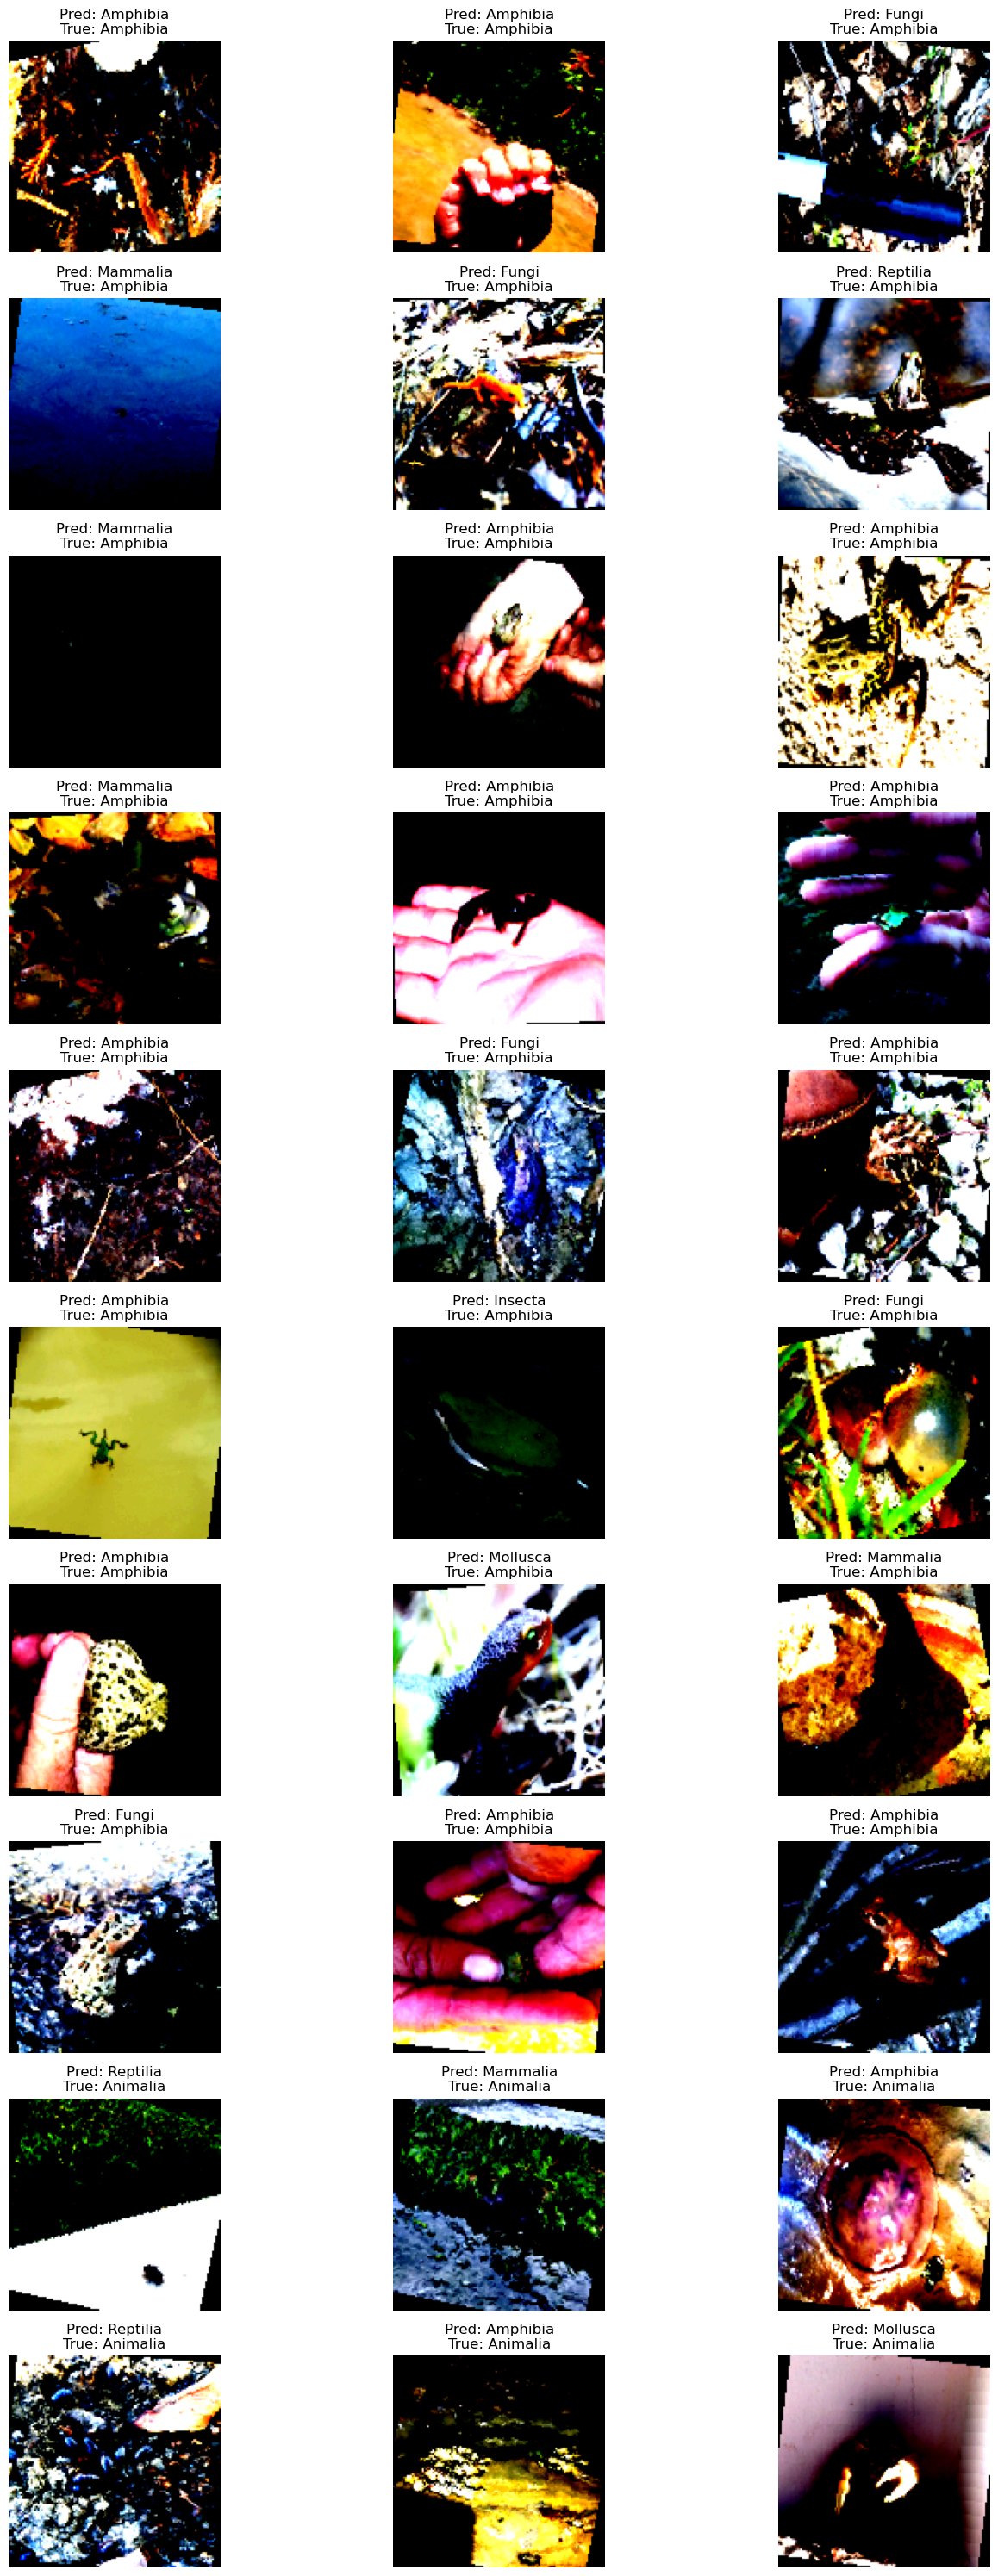

In [26]:
evaluate_best_model()